# **Modeling Notebook**

- This Notebook will be used for testing different models which will then be included in the final Vignette report.

We will be testing the following models:
- **Simple CNN**
    - 2 Convolution Layers with 64 layers each
    - Maxpooling
    - and a Dense Layer with 128 nodes with a dropout of 50%
- **Hyperband Parameter Training**
    - Uses Keras Hyperband Tuning to start with different architectures at lower epochs and slowly removes unpromising setups, and keeps the best ones and trains further
- **Gray-Level Co-occurence Matrix + CNN Model**

Considerations:
- Do we need to consider a better data set?
- how can we get better performance?

In [1]:
##### library imports ##### 

# preprocessing and splitting data packages
import os
from Preprocessing import preprocess_data
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
# modeling data packages
import keras
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Precision, Recall, AUC
from skimage.feature import graycomatrix, graycoprops
import pandas as pd

# set random seeds
np.random.seed(12345)
tf.random.set_seed(12345)
keras.utils.set_random_seed(12345)

# Preprocess Data from Preprocessing file

- Pulls 400 Brain Tumor MRI images from each of 4 different classes, including:
    - Glioma
    - Meningioma  
    - Pituitary
    - Normal (no tumor)

- Ensures they are normalizes, resized, and Grayscaled for quicker computation

In [6]:
my_dir = os.getcwd()
print(f"Current working directory: {my_dir}")

# change this accordingly but should work for all users
glioma_path = my_dir[:-15] + "/data/glioma_tumor"
meningioma_path = my_dir[:-15] + "/data/meningioma_tumor"
pituitary_path = my_dir[:-15] + "/data/pituitary_tumor"
normal_path = my_dir[:-15] + "/data/normal_tumor"


# preprocess data
n_samples = 600 # more than 600 in each class
seed = 1234 # reproducibility
glioma_data, glioma_labels = preprocess_data(glioma_path, n_samples, seed)
print("processed glioma data")
print(glioma_data.shape)
meningioma_data, meningioma_labels = preprocess_data(meningioma_path, n_samples, seed)
print("processed meningioma data")
print(meningioma_data.shape)
pituitary_data, pituitary_labels = preprocess_data(pituitary_path, n_samples, seed)
print("processed pituitary data")
print(pituitary_data.shape)
normal_data, normal_labels = preprocess_data(normal_path, n_samples, seed)
print("processed normal data")
print(normal_data.shape)
if glioma_data.shape != meningioma_data.shape or pituitary_data.shape != normal_data.shape:
    raise ValueError("All data must have the same shape")
else:
    print("All data have the same shape")

# combine all data and labels
data = np.concatenate([glioma_data, meningioma_data, pituitary_data, normal_data])
labels = np.concatenate([glioma_labels, meningioma_labels, pituitary_labels, normal_labels])
print(f"Combined data and labels shape: {data.shape}, {labels.shape}")

# split data into training and testing and validation sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)
train_small, val_data, train_small_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, random_state=42)

# one hot encode labels
label_encoder = OneHotEncoder(sparse_output=False)
train_labels = label_encoder.fit_transform(np.array(train_labels).reshape(-1, 1))
test_labels = label_encoder.transform(np.array(test_labels).reshape(-1, 1))
train_small_labels = label_encoder.transform(np.array(train_small_labels).reshape(-1, 1))
val_labels = label_encoder.transform(np.array(val_labels).reshape(-1, 1))

Current working directory: /Users/reese/Documents/School/UC Santa Barbra/PSTAT/PSTAT197/vignette-cnn/scripts/drafts
Total files in /Users/reese/Documents/School/UC Santa Barbra/PSTAT/PSTAT197/vignette-cnn/data/glioma_tumor: 901
Selected files: 600
Processed 600 images.
processed glioma data
(600, 128, 128, 1)
Total files in /Users/reese/Documents/School/UC Santa Barbra/PSTAT/PSTAT197/vignette-cnn/data/meningioma_tumor: 913
Selected files: 600
Processed 600 images.
processed meningioma data
(600, 128, 128, 1)
Total files in /Users/reese/Documents/School/UC Santa Barbra/PSTAT/PSTAT197/vignette-cnn/data/pituitary_tumor: 843
Selected files: 600
Processed 600 images.
processed pituitary data
(600, 128, 128, 1)
Total files in /Users/reese/Documents/School/UC Santa Barbra/PSTAT/PSTAT197/vignette-cnn/data/normal_tumor: 633
Selected files: 600
Processed 600 images.
processed normal data
(600, 128, 128, 1)
All data have the same shape
Combined data and labels shape: (2400, 128, 128, 1), (2400,)


# Visually Inspect

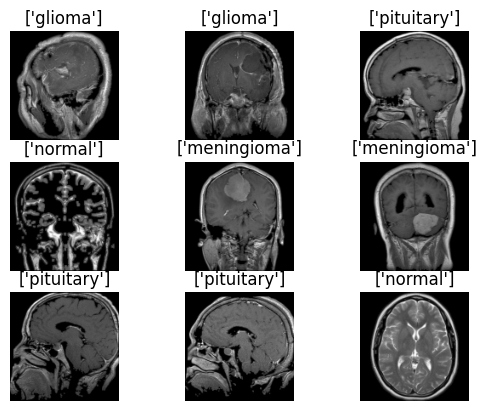

In [7]:
# inverse transform labels
labels = label_encoder.inverse_transform(train_labels)

# show images from training set
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_data[i], cmap="gray")
    plt.axis('off')
    plt.title((labels[i]))
plt.show()

# Modeling
- ### We first can start with a simple convolution model as a base level to see how well one archictecture will learn on the training data set.
- ### Next, we will apply a hyperparameter tuning technique, called Hyperband tuning, to find the best setup.
     - Hyperband tuning performs a combination of random search and early stopping to efficiently explore hyperparameter configurations. It allocates resources to promising configurations while quickly discarding those that are underperforming, allowing for faster convergence to optimal hyperparameters.

# Simple CNN to Start

### What is a CNN?
A CNN (convolutional neural network) is a type of network that specializes in processing and predicting grid-like data, making it especially useful for image classification. It utilizes automatic detection of spatial hierarchies and patterns with layers of convolutional filters. Unlike the classic feed-forward network, which connects each neuron to every neuron in the next layer, a CNN uses local receptive fields and shared weights in its convolutional layers, which reduces the number of parameters significantly, and improves the efficiency of the model. 

### Model Flow
- In our example, the filters will pickup on different shapes, edges, and other patterns in the image, by sliding multiple 3x3 kernels convolving with the input image.
- After this we, apply a pooling function of either averaging or maximizing which typically halves the size of our convolved feature.
- Then after another round of convolving and maxpool, we flatten it and pass to a Dense neural network of hidden layers
- Finally the output layer is activated by a softmax function to provide us with probabilities of the classes. 

In [23]:
# Initialize model
model = Sequential([
  Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(128, 128, 1)),
  MaxPooling2D(2), # reduce dimensionality
  Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
  MaxPooling2D(2), # reduce dimensionality
  Flatten(), # flatten the data to feed into the dense layers
  Dense(units=128, activation='relu'),
  Dropout(0.5), # prevent overfitting
  Dense(units=4, activation='softmax') # output layer
])

model.compile(optimizer=keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 126, 126, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 61, 61, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,820,740 (56.54 MB)

 Trainable params: 14,820,740 (56.54 MB)

 Non-trainable params: 0 (0.00 B)

# Training the model

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 327ms/step - accuracy: 0.7476 - loss: 0.6664 - val_accuracy: 0.7370 - val_loss: 0.7268
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 345ms/step - accuracy: 0.7863 - loss: 0.5524 - val_accuracy: 0.7682 - val_loss: 0.6348
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 335ms/step - accuracy: 0.8448 - loss: 0.4248 - val_accuracy: 0.7943 - val_loss: 0.6243
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 326ms/step - accuracy: 0.8687 - loss: 0.3383 - val_accuracy: 0.8125 - val_loss: 0.6550
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 318ms/step - accuracy: 0.8955 - loss: 0.2751 - val_accuracy: 0.8099 - val_loss: 0.6283
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 316ms/step - accuracy: 0.8935 - loss: 0.2810 - val_accuracy: 0.7656 - val_loss: 0.7703
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 317ms/step - accuracy: 0.8837 - loss: 0.2949 - val_accuracy: 0.7812 - val_loss: 0.6843
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 345ms/step - accuracy: 0.9295 - loss: 0.1952 - val_accu

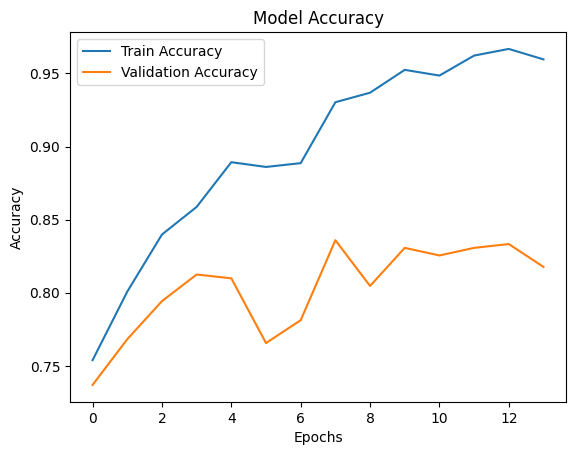

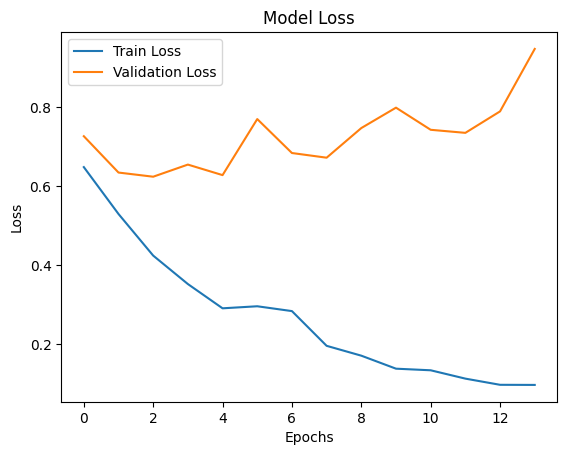

In [25]:
# Train the model # 

# Early stopping will stop training when the validation loss stops improving for a few epochs, preventing overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=6, verbose=1, restore_best_weights=True)

history = model.fit(
    train_data,
    train_labels,
    validation_split=0.2, # Convert sparse matrix
    epochs=20,
    batch_size=32, # mini batch size
    callbacks=[early_stopping]
)

# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# TODO LATER once decent performance on simple CNN:
HyperParameter Tuning
- We will apply Hyperband Parameter Tuning to find our best set of params
- Then once we have the best set of hyperparams, we will build a final model and train with those parameters on the full training set.

In [8]:
# building a hyperband model to find the best model architecture
def build_model(hp):
    '''Hyperband function to test different model architectures'''
    # initialize the model
    model = Sequential([
        Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
               kernel_size=hp.Choice('conv_1_kernel', values=[3,5]),
               activation='relu', input_shape=(128, 128, 1)),
        MaxPooling2D(2),
        Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=256, step=32),
               kernel_size=hp.Choice('conv_2_kernel', values=[3,5]),
               activation='relu'),
        MaxPooling2D(2),
        Conv2D(filters=hp.Int('conv_3_filter', min_value=32, max_value=256, step=32),
               kernel_size=3,
               activation='relu'),
        MaxPooling2D(2),
        Flatten(),
        Dense(units=hp.Int('dense_1_units', min_value=128, max_value=512, step=32),
              activation='relu'),
        Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(4, activation='softmax')
    ])
    # compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model
# initialize tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=5,
    directory=my_dir[:-15] + "/scripts/drafts/model_trials",  # Use temporary directory
    project_name='hp_tuning',
    overwrite=False
)
# search for the best hyperparameters
early_stopping = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
tuner.search(
    train_small, train_small_labels,
    epochs=5,
    batch_size=32, 
    validation_data=(val_data, val_labels),
    callbacks=[early_stopping],
    verbose=1
)
# Get the best hyperparameters directly
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(best_hp.values)
# build the best model
Hyperband_model = tuner.hypermodel.build(best_hp)
Hyperband_model.compile(optimizer=keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
Hyperband_model.summary()

Reloading Tuner from /Users/reese/Documents/School/UC Santa Barbra/PSTAT/PSTAT197/vignette-cnn/scripts/drafts/model_trials/hp_tuning/tuner0.json
Best Hyperparameters:
{'conv_1_filter': 96, 'conv_1_kernel': 3, 'conv_2_filter': 128, 'conv_2_kernel': 3, 'conv_3_filter': 128, 'dense_1_units': 320, 'dropout_1': 0.4, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 96)   │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 320)            │     8,028,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,284 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,289,028 (31.62 MB)

 Trainable params: 8,289,028 (31.62 MB)

 Non-trainable params: 0 (0.00 B)

Once we have our best model, we can then build using the best architecture and train on the full data set.

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 27s 521ms/step - accuracy: 0.4688 - loss: 1.1663 - val_accuracy: 0.6667 - val_loss: 0.8749
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 550ms/step - accuracy: 0.6963 - loss: 0.8028 - val_accuracy: 0.7153 - val_loss: 0.7114
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 560ms/step - accuracy: 0.7530 - loss: 0.6342 - val_accuracy: 0.7778 - val_loss: 0.6116
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 558ms/step - accuracy: 0.8576 - loss: 0.4110 - val_accuracy: 0.7500 - val_loss: 0.6779
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 545ms/step - accuracy: 0.8730 - loss: 0.3231 - val_accuracy: 0.8229 - val_loss: 0.6761
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 557ms/step - accuracy: 0.8948 - loss: 0.2612 - val_accuracy: 0.7743 - val_loss: 0.7717
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 555ms/step - accuracy: 0.9481 - loss: 0.1487 - val_accuracy: 0.8021 - val_loss: 0.7201
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 568ms/step - accuracy: 0.9224 - loss: 0.2114 - val_accu

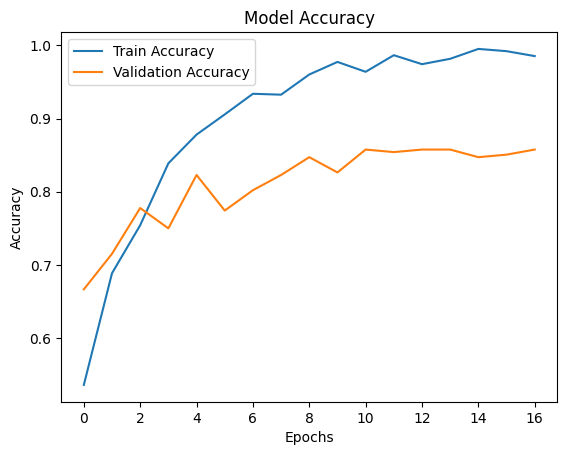

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - accuracy: 0.8266 - loss: 0.8839
Test Loss: 0.8585119843482971
Test Accuracy: 0.8291666507720947


In [20]:
# early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)
history = Hyperband_model.fit(train_data, train_labels, 
                epochs=50,
                validation_split=0.15,  
                batch_size=32,
                callbacks=[early_stopping])

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# evaluate the best model on the test set
Hyperband_test_loss, Hyperband_test_accuracy = Hyperband_model.evaluate(test_data, test_labels)
print(f"Test Loss: {Hyperband_test_loss}")
print(f"Test Accuracy: {Hyperband_test_accuracy}")

### Combining with GLCM
- Extract features from the cnn and the GLCM and combine to see if the model improves

In [29]:
def feature_extractor(image):
    '''Extract GLCM features from an image'''
    # change to 2d image from 3d
    image = image.squeeze()
    image = (image * 255).astype(np.uint8) # normalize back to 0-255 (instead of 0-1)
    glcm = graycomatrix(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    # extract features
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    asm = graycoprops(glcm, 'ASM')[0, 0]
    return [contrast, dissimilarity, homogeneity, energy, correlation, asm]

In [31]:
glcm_features_train = np.array([feature_extractor(img) for img in train_data])
glcm_features_test = np.array([feature_extractor(img) for img in test_data])

for the combined, we will 
1. feed the images through a cnn until the output layer
2. Then feed glcm features into a few dense layers,
3. Combine features by concatenating and feed into a dense layer,
4. and get the predicted outcome

In [38]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate

def build_cnn(best_hp):
    '''Builds a CNN model from the best tuned hyperparameters and returns the model'''
    input_img = Input(shape=(128, 128, 1), name='original_image')
    x = Conv2D(filters=best_hp.get('conv_1_filter'), kernel_size=best_hp.get('conv_1_kernel'), activation='relu', name='conv_1')(input_img)
    x = MaxPooling2D(2, name='pool_1')(x)
    x = Conv2D(filters=best_hp.get('conv_2_filter'), kernel_size=best_hp.get('conv_2_kernel'), activation='relu', name='conv_2')(x)
    x = MaxPooling2D(2, name='pool_2')(x)
    x = Conv2D(filters=best_hp.get('conv_3_filter'), kernel_size=3, activation='relu', name='conv_3')(x)
    x = MaxPooling2D(2, name='pool_3')(x)
    x = Flatten(name='flatten')(x)
    return Model(inputs=input_img, outputs=x, name='cnn_model')

def build_glcm():
    '''Builds a GLCM model and returns the model'''
    input_glcm = Input(shape=(glcm_features_train.shape[1],), name='Extracted_traditional_features')
    x = Dense(units=64, activation='relu', name='dense_glcm_1')(input_glcm)
    x = Dropout(rate=0.3, name='dropout_glcm_1')(x)
    x = Dense(units=4, activation='relu', name='dense_glcm_2')(x)
    return Model(inputs=input_glcm, outputs=x, name='glcm_model')


In [39]:
# build the model
cnn_model = build_cnn(best_hp)
glcm_model = build_glcm()
# get the cnn features
cnn_features_train = cnn_model.predict(train_data)
glcm_features_train = glcm_model.predict(glcm_features_train)

# combine the cnn features and the glcm features
combined_features_train = np.concatenate([cnn_features_train, glcm_features_train], axis=1)

combined_model = Sequential([
    Dense(units=32, activation='relu', input_shape=(combined_features_train.shape[1],)),
    Dropout(rate=0.3),
    Dense(4, activation='softmax') # output layer
])

combined_model.compile(optimizer=keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy', 'AUC'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)
combined_model.fit(combined_features_train, train_labels,
                   epochs = 50,
                   batch_size=32,
                   validation_split=0.2,
                   callbacks=[early_stopping])

60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step
Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.5504 - accuracy: 0.2961 - loss: 1.3840 - val_AUC: 0.7301 - val_accuracy: 0.5026 - val_loss: 1.2982
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6552 - accuracy: 0.3590 - loss: 1.3093 - val_AUC: 0.7743 - val_accuracy: 0.5547 - val_loss: 1.2410
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7031 - accuracy: 0.4332 - loss: 1.2510 - val_AUC: 0.8157 - val_accuracy: 0.5625 - val_loss: 1.1781
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7531 - accuracy: 0.4580 - loss: 1.1917 - val_AUC: 0.8375 - val_accuracy: 0.6016 - val_loss: 1.1215
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7665 - accuracy: 0.4818 - loss: 1.1505 - val_AUC: 0.8530 - val_accuracy: 0.6302 - val_loss: 1.0776
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7962 - accuracy: 0.5295 - loss: 1.1025 - val_AUC: 0.8749 - val_accura

In [41]:
combined_features_test = cnn_model.predict(test_data)
glcm_features_test = glcm_model.predict(glcm_features_test)
combined_features_test = np.concatenate([combined_features_test, glcm_features_test], axis=1)
combined_test_loss, combined_test_accuracy, combined_test_auc = combined_model.evaluate(combined_features_test, test_labels)
print(f"Test Loss: {combined_test_loss}")
print(f"Test Accuracy: {combined_test_accuracy}")
print(f"Test AUC: {combined_test_auc}")


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step


2024-12-07 14:32:14.537838: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Matrix size-incompatible: In[0]: [32,6], In[1]: [4,64]
	 [[{{node glcm_model_1/dense_glcm_1_1/MatMul}}]]


InvalidArgumentError: Graph execution error:

Detected at node glcm_model_1/dense_glcm_1_1/MatMul defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/reese/Library/Python/3.11/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/reese/Library/Python/3.11/lib/python/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/reese/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/reese/Library/Python/3.11/lib/python/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 1919, in _run_once

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/Users/reese/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 542, in dispatch_queue

  File "/Users/reese/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 531, in process_one

  File "/Users/reese/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/reese/Library/Python/3.11/lib/python/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/Users/reese/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 775, in execute_request

  File "/Users/reese/Library/Python/3.11/lib/python/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/Users/reese/Library/Python/3.11/lib/python/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/reese/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/Users/reese/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/Users/reese/Library/Python/3.11/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/reese/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/Users/reese/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/Users/reese/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/var/folders/xh/4xpwy9dj7glg3lpzyn0wwqgw0000gn/T/ipykernel_83860/4290623105.py", line 2, in <module>

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 510, in predict

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 208, in one_step_on_data_distributed

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 198, in one_step_on_data

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 96, in predict_step

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/models/functional.py", line 182, in call

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/models/functional.py", line 584, in call

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py", line 144, in call

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/ops/numpy.py", line 3733, in matmul

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/backend/tensorflow/numpy.py", line 477, in matmul

Matrix size-incompatible: In[0]: [32,6], In[1]: [4,64]
	 [[{{node glcm_model_1/dense_glcm_1_1/MatMul}}]] [Op:__inference_one_step_on_data_distributed_300452]

## Comparing Hyperband Model with Combined GLCM + Tuned CNN Model

In [ ]:
# plot the performance of the optimized model and the combined featurs model
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].bar(['Hyperband Model', 'Combined Features Model'], [Hyperband_test_accuracy, combined_test_accuracy], color=['blue', 'red'])
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Model Accuracy')
ax[1].bar(['Hyperband Model', 'Combined Features Model'], [combined_test_accuracy, Hyperband_test_accuracy], color=['blue', 'red'])
ax[1].set_ylabel('AUC')
ax[1].set_title('Model AUC')
plt.show()